In [1]:
import xarray as xr
from pathlib import Path
from easygems import healpix as egh
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import healpy as hp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy.linalg as la
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec

In [ ]:
### diurnal time series

In [24]:
era_lmsk = xr.open_dataset("/g/data/rt52/era5/single-levels/reanalysis/lsm/2020/lsm_era5_oper_sfc_20200401-20200430.nc"
               ).isel(time=slice(0,48)).groupby('time.hour').mean()
era_offshore = xr.open_dataset('/g/data/nf33/hk25_AusNode_coastal/era5_global_angles.nc').rename(
    {'lon': 'longitude', 'lat': 'latitude'}).assign_coords(hour = era_lmsk.hour)[['min_coast_dist']]

def era_slice(ds):
    era_land = ds.where(era_lmsk['lsm'] > 0.5)
    era_ocean = ds.where((era_lmsk['lsm'] < 0.5) & (era_offshore['min_coast_dist'] > 50))
    era_coast = ds.where((era_lmsk['lsm'] < 0.5) & (era_offshore['min_coast_dist'] < 50))

    mc_windocn_era = era_ocean.where((era_ocean.longitude <= 170.0) & (era_ocean.longitude >= 90.0) &
                    (era_ocean.latitude >= -15.0) & (era_ocean.latitude <= 10.0), drop=True
                                 ).mean(['latitude','longitude'])
    mc_windlnd_era = era_land.where((era_land.longitude <= 170.0) & (era_land.longitude >= 90.0) &
                    (era_land.latitude >= -15.0) & (era_land.latitude <= 10.0), drop=True
                               ).mean(['latitude','longitude'])
    mc_windcst_era = era_coast.where((era_coast.longitude <= 170.0) & (era_coast.longitude >= 90.0) &
                    (era_coast.latitude >= -15.0) & (era_coast.latitude <= 10.0), drop=True
                               ).mean(['latitude','longitude'])

    return mc_windlnd_era, mc_windocn_era, mc_windcst_era


In [25]:
ds_erawinds1 = xr.open_dataset("/g/data/nf33/hk25_AusNode_coastal/ae7501/era_hourly_avg1.nc").rename(
    {'__xarray_dataarray_variable__': 'wind_speed'})
ds_erawinds2 = xr.open_dataset("/g/data/nf33/hk25_AusNode_coastal/ae7501/era_hourly_avg2.nc").rename(
    {'__xarray_dataarray_variable__': 'wind_speed'})
ds_erawinds = ((ds_erawinds1 + ds_erawinds2)/2)
mc_windlnd_era, mc_windocn_era, mc_windcst_era = era_slice(ds_erawinds)
#mc_windlnd_era1, mc_windocn_era1 = era_slice(ds_erawinds1)
#mc_windlnd_era2, mc_windocn_era2 = era_slice(ds_erawinds2)

ds_eraprcp1 = xr.open_dataset("/scratch/nf33/hl1052/hackthon2025_pr/era5_pr_Apr_Sep_hourly.nc")
ds_eraprcp2 = xr.open_dataset("/scratch/nf33/hl1052/hackthon2025_pr/era5_pr_Oct_Mar_hourly.nc")
ds_eraprcp = ((ds_eraprcp1 + ds_eraprcp2)/2)
mc_prcplnd_era, mc_prcpocn_era, mc_prcpcst_era = era_slice(ds_eraprcp)
#mc_prcplnd_era1, mc_prcpocn_era1 = era_slice(ds_eraprcp1)
#mc_prcplnd_era2, mc_prcpocn_era2 = era_slice(ds_eraprcp2)

In [21]:
data_2d_z8 = "/g/data/nf33/hk25_AusNode_coastal/sftlf_um_z8.zarr"
um_lmsk = xr.open_zarr(data_2d_z8)

data_2d_z8 = "/g/data/nf33/hk25_AusNode_coastal/um_angles_z8.zarr"
um_coast = xr.open_zarr(data_2d_z8)[['min_coast_dist']]

def um_slice(ds):
    ds_land = ds.where(um_lmsk['sftlf'] > 0.5)
    ds_ocean = ds.where((um_lmsk['sftlf'] < 0.5) & (um_coast['min_coast_dist'] > 50)).assign(
        lat= ds_land.lat, lon= ds_land.lon)
    ds_coast = ds.where((um_lmsk['sftlf'] < 0.5) & (um_coast['min_coast_dist'] < 50)).assign(
        lat= ds_land.lat, lon= ds_land.lon)
    
    mc_ocn_um = ds_ocean.where((ds_ocean.lon <= 170.0) & (ds_ocean.lon >= 90.0) &
                    (ds_ocean.lat >= -15.0) & (ds_ocean.lat <= 10.0), drop=True).mean('cell')
    mc_lnd_um = ds_land.where((ds_land.lon <= 170.0) & (ds_land.lon >= 90.0) &
                    (ds_land.lat >= -15.0) & (ds_land.lat <= 10.0), drop=True).mean('cell')
    mc_cst_um = ds_coast.where((ds_coast.lon <= 170.0) & (ds_coast.lon >= 90.0) &
                    (ds_coast.lat >= -15.0) & (ds_coast.lat <= 10.0), drop=True).mean('cell')
    return mc_lnd_um, mc_ocn_um, mc_cst_um

In [22]:
ds_umwinds1 = xr.open_dataset('/g/data/nf33/hk25_AusNode_coastal/ae7501/UM__hourly_avg_velocity1.nc').rename(
    {'__xarray_dataarray_variable__': 'wind_speed'})
ds_umwinds2 = xr.open_dataset('/g/data/nf33/hk25_AusNode_coastal/ae7501/UM__hourly_avg_velocity2.nc').rename(
    {'__xarray_dataarray_variable__': 'wind_speed'})
ds_umwinds = ((ds_umwinds1 + ds_umwinds2)/2)
mc_windlnd_um, mc_windocn_um, mc_windcst_um = um_slice(ds_umwinds)
#mc_windlnd_um1, mc_windocn_um1 = um_slice(ds_umwinds1)
#mc_windlnd_um2, mc_windocn_um2 = um_slice(ds_umwinds2)


ds_umprcp1 = xr.open_dataset("/scratch/nf33/hl1052/hackthon2025_pr/um_pr_Apr_Sep_hourly.nc").assign(
    lat= ds_umwinds.lat, lon= ds_umwinds.lon)
ds_umprcp2 = xr.open_dataset("/scratch/nf33/hl1052/hackthon2025_pr/um_pr_Oct_Mar_hourly.nc").assign(
    lat= ds_umwinds.lat, lon= ds_umwinds.lon)
ds_umprcp = ((ds_umprcp1 + ds_umprcp2)/2)
mc_prcplnd_um, mc_prcpocn_um, mc_prcpcst_um = um_slice(ds_umprcp)
#mc_prcplnd_um1, mc_prcpocn_um1 = um_slice(ds_umprcp1)
#mc_prcplnd_um2, mc_prcpocn_um2 = um_slice(ds_umprcp2)


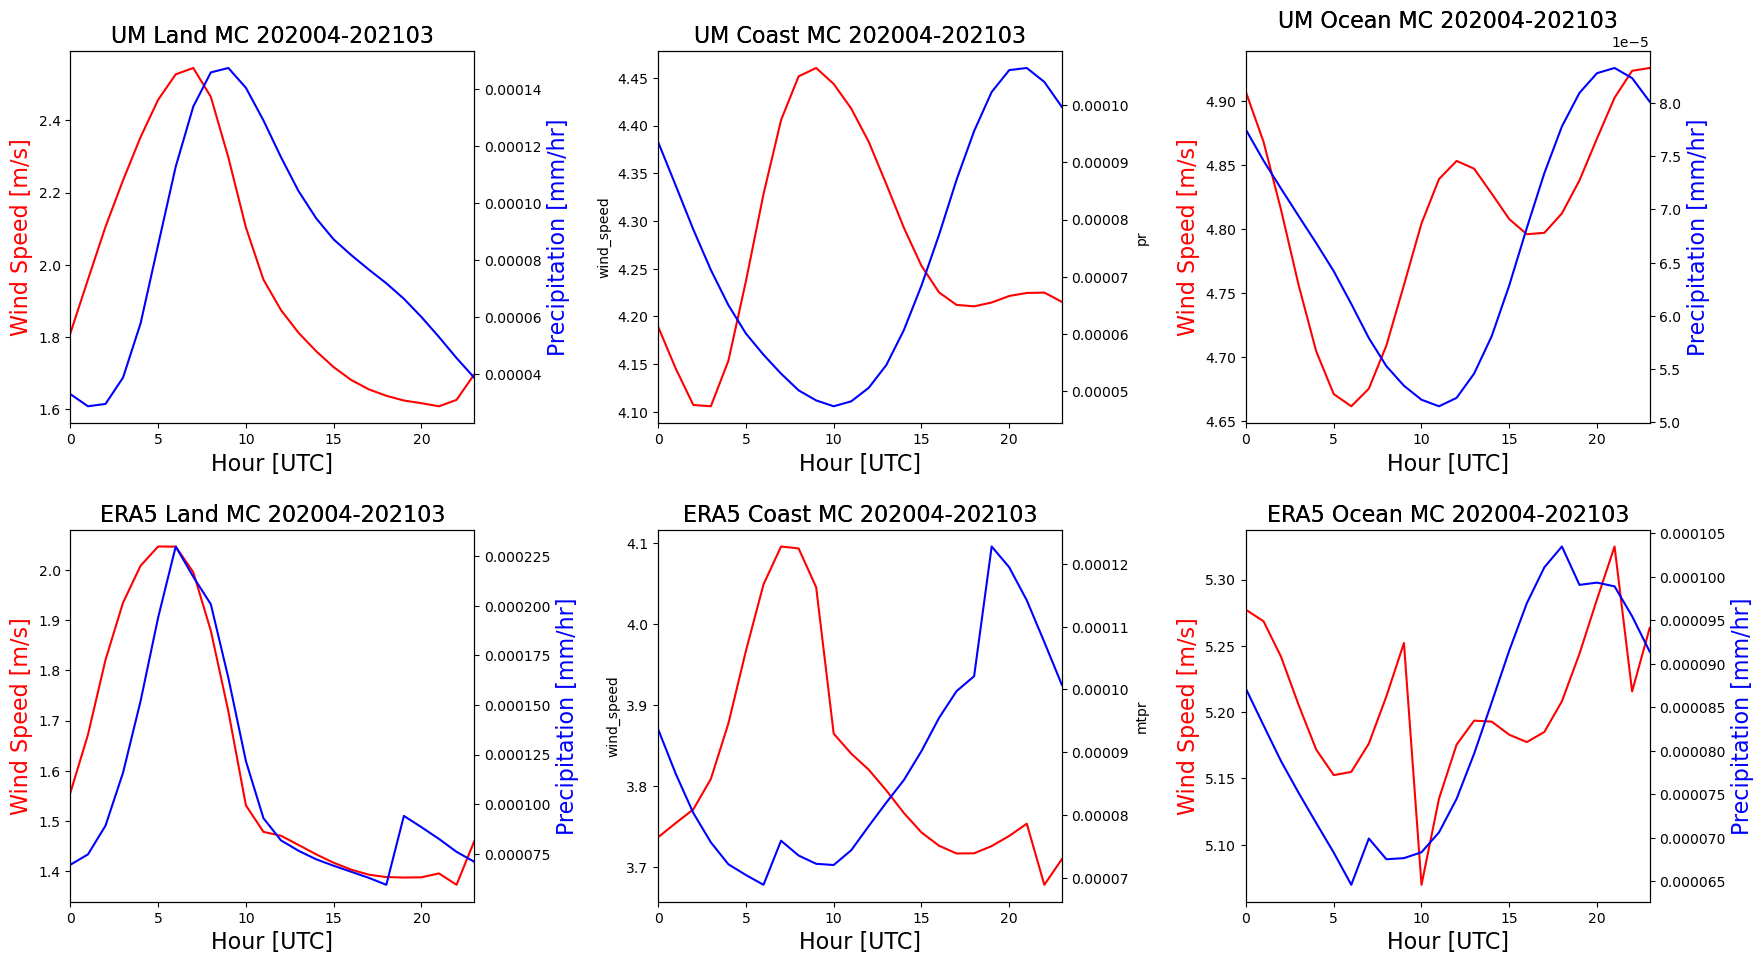

In [26]:
fs = 16
fig = plt.figure(figsize=(18,10))
gs = GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0,0])
mc_windlnd_um.wind_speed.plot(ax=ax1, color='r', label='UM Wind Speed')

ax2 = ax1.twinx()
mc_prcplnd_um.pr.plot(ax=ax2, color='b', label='UM Precipitation')
ax1.set_title('UM Land MC 202004-202103', fontsize=fs)
ax2.set_title('UM Land MC 202004-202103', fontsize=fs)
#mtpr

ax3 = fig.add_subplot(gs[1,0])
mc_windlnd_era.wind_speed.plot(ax=ax3, color='r', label='ERA5 Wind Speed')

ax4 = ax3.twinx()
mc_prcplnd_era.mtpr.plot(ax=ax4, color='b', label='ERA5 Precipitation')
ax3.set_title('ERA5 Land MC 202004-202103', fontsize=fs)
ax4.set_title('ERA5 Land MC 202004-202103', fontsize=fs)


ax10 = fig.add_subplot(gs[0,1])
mc_windcst_um.wind_speed.plot(ax=ax10, color='r', label='UM Wind Speed')

ax20 = ax10.twinx()
mc_prcpcst_um.pr.plot(ax=ax20, color='b', label='UM Precipitation')
ax10.set_title('UM Coast MC 202004-202103', fontsize=fs)
ax20.set_title('UM Coast MC 202004-202103', fontsize=fs)
#mtpr

ax30 = fig.add_subplot(gs[1,1])
mc_windcst_era.wind_speed.plot(ax=ax30, color='r', label='ERA5 Wind Speed')

ax40 = ax30.twinx()
mc_prcpcst_era.mtpr.plot(ax=ax40, color='b', label='ERA5 Precipitation') 
ax30.set_title('ERA5 Coast MC 202004-202103', fontsize=fs)
ax40.set_title('ERA5 Coast MC 202004-202103', fontsize=fs)


ax100 = fig.add_subplot(gs[0,2])
mc_windocn_um.wind_speed.plot(ax=ax100, color='r', label='UM Wind Speed')

ax200 = ax100.twinx()
mc_prcpocn_um.pr.plot(ax=ax200, color='b', label='UM Precipitation')
ax100.set_title('UM Ocean MC 202004-202103', fontsize=fs)
ax200.set_title('UM Ocean MC 202004-202103', fontsize=fs)
#mtpr

ax300 = fig.add_subplot(gs[1,2])
mc_windocn_era.wind_speed.plot(ax=ax300, color='r', label='ERA5 Wind Speed')

ax400 = ax300.twinx()
mc_prcpocn_era.mtpr.plot(ax=ax400, color='b', label='ERA5 Precipitation') 
ax300.set_title('ERA5 Ocean MC 202004-202103', fontsize=fs)
ax400.set_title('ERA5 Ocean MC 202004-202103', fontsize=fs)

for ax in [ax1,ax3]:
    #ax.set_ylim(.3,2.8)
    ax.set_ylabel('Wind Speed [m/s]', c='r', fontsize=fs)
for ax in [ax2,ax4]:
    #ax.set_ylim(0.00002,0.00023)
    ax.set_ylabel('Precipitation [mm/hr]', c='b', fontsize=fs)

for ax in [ax100,ax300]:
    #ax.set_ylim(4.6,5.2)
    ax.set_ylabel('Wind Speed [m/s]', c='r', fontsize=fs)
for ax in [ax200,ax400]:
    #ax.set_ylim(0.00004,0.00010)
    ax.set_ylabel('Precipitation [mm/hr]', c='b', fontsize=fs)

for ax in fig.axes:
    ax.set_xlabel('Hour [UTC]', fontsize=fs)
    ax.set_xlim(0,23)

plt.tight_layout(pad=2)
plt.savefig('/g/data/nf33/hk25_AusNode_coastal/eb7331/windprecip_202004-202103.jpeg')